# Get data from server

In [1]:
import pymysql
import pandas as pd

from dotenv import load_dotenv
from os import getenv

In [5]:
load_dotenv(dotenv_path = '.env')

conn = pymysql.connect(host = getenv('host'),
                       port = int(getenv('port')),
                       user = getenv('user'),
                       passwd = getenv('password'),
                       db = 'financial')

In [7]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:

    table = pd.read_sql("select * from `%s`" % name, conn)
    table.to_csv('tables/%s.csv' % name, index = False)
    print(table.tail(2))
    print('')

      account_id  district_id         frequency        date
4498       11362           67  POPLATEK MESICNE  1995-10-14
4499       11382           74  POPLATEK MESICNE  1995-08-20

     card_id  disp_id     type      issued
890     1239    13442   junior  1998-02-02
891     1247    13660  classic  1995-06-13

      client_id gender  birth_date  district_id
5367      13971      F  1962-10-19           67
5368      13998      F  1953-08-12           74

      disp_id  client_id  account_id   type
5367    13663      13971       11362  OWNER
5368    13690      13998       11382  OWNER

    district_id       A2             A3      A4  A5  A6  A7  A8  A9   A10  \
75           76  Sumperk  north Moravia  127369  31  32  13   2   7  51.2   
76           77   Vsetin  north Moravia  148545   8  35  12   3   4  53.5   

     A11  A12   A13  A14     A15   A16  
75  8369  4.7  5.88  107  3736.0  2807  
76  8909  4.0  5.56  113  3460.0  3590  

     loan_id  account_id        date  amount  duration 

In [8]:
#Close connection
conn.close()

# Load in data

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

In [3]:
tables = ['account','card','client','disp','district','loan','order','trans']

for name in tables:
    exec("%s = pd.read_csv('tables/%s.csv')" % (name,name))

    exec("print(%s.tail(2))" % name)
    print('')

      account_id  district_id         frequency        date
4498       11362           67  POPLATEK MESICNE  1995-10-14
4499       11382           74  POPLATEK MESICNE  1995-08-20

     card_id  disp_id     type      issued
890     1239    13442   junior  1998-02-02
891     1247    13660  classic  1995-06-13

      client_id gender  birth_date  district_id
5367      13971      F  1962-10-19           67
5368      13998      F  1953-08-12           74

      disp_id  client_id  account_id   type
5367    13663      13971       11362  OWNER
5368    13690      13998       11382  OWNER

    district_id       A2             A3      A4  A5  A6  A7  A8  A9   A10  \
75           76  Sumperk  north Moravia  127369  31  32  13   2   7  51.2   
76           77   Vsetin  north Moravia  148545   8  35  12   3   4  53.5   

     A11  A12   A13  A14     A15   A16  
75  8369  4.7  5.88  107  3736.0  2807  
76  8909  4.0  5.56  113  3460.0  3590  

     loan_id  account_id        date  amount  duration 

/home/steve/Desktop/Unit5_Project/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# SQL merges

In [4]:
# 'A' stands for contract finished, no problems,
# 'B' stands for contract finished, loan not payed,
# 'C' stands for running contract, OK so far,
# 'D' stands for running contract, client in debt

loan['status2'] = loan.status

loan.loc[loan['status2']=='C','status2'] = 'A'
loan.loc[loan['status2']=='B','status2'] = 'D'

In [5]:
#Join card and disp
disp_card = disp.drop(columns=['type']).merge(card,on='disp_id').drop(columns=['card_id','disp_id'])

#Join client and disp
disp_cc = disp_card.merge(client,on='client_id').drop(columns=['client_id','district_id'])

#Join disp and account
account_disp = account.merge(disp_cc,on='account_id')

In [6]:
account_disp.head(2)

,account_id,district_id,frequency,date,type,issued,gender,birth_date
0,7,60,POPLATEK MESICNE,1996-11-24,gold,1998-10-16,M,1935-10-16
1,14,47,POPLATEK MESICNE,1996-11-27,classic,1998-03-13,M,1942-12-28


In [7]:
#inner join order onto loan
loan_o = loan.merge(order,on='account_id',
                    suffixes=('_loan','_order')).drop(columns=['order_id','account_to','k_symbol'])

#inner join trans onto loan
loan_ot = loan_o.merge(trans.drop(columns=['date','trans_id','bank','account','k_symbol','operation']),
                       on='account_id',suffixes=('_order','_trans'))

In [8]:
loan_ot.head()

,loan_id,account_id,date,amount_loan,duration,payments,status,status2,bank_to,amount_order,type,amount,balance
0,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,1100,1100
1,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,20236,21336
2,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,20236,45286
3,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,20236,54631
4,4959,2,1994-01-05,80952,24,3373.0,A,A,ST,3372.7,PRIJEM,30354,67530


In [9]:
#Join final loan with final account
loan_account = loan_ot.merge(account_disp,on='account_id',suffixes=('_loan','_account'))

In [10]:
loan_account.head(2)

,loan_id,account_id,date_loan,amount_loan,duration,payments,status,status2,bank_to,amount_order,type_loan,amount,balance,district_id,frequency,date_account,type_account,issued,gender,birth_date
0,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,900,900,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28
1,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,17928,18828,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28


In [11]:
#Join final loan/account with district
loan_final = loan_account.merge(district,on='district_id').drop(columns=['A2','A12','A15'])

In [12]:
loan_final.head(2)

,loan_id,account_id,date_loan,amount_loan,duration,payments,status,status2,bank_to,amount_order,type_loan,amount,balance,district_id,frequency,date_account,type_account,issued,gender,birth_date,A3,A4,A5,A6,A7,A8,A9,A10,A11,A13,A14,A16
0,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,900,900,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347
1,4986,97,1997-08-10,102876,12,8573.0,A,A,ST,1436.0,PRIJEM,17928,18828,74,POPLATEK MESICNE,1996-05-05,classic,1998-06-23,M,1942-01-28,north Moravia,323870,0,0,0,1,1,100.0,10673,5.44,100,18347


In [13]:
data = loan_final.drop(columns=['status','loan_id','account_id','date_loan','date_account','issued','birth_date'])

In [14]:
data.columns

Index(['amount_loan', 'duration', 'payments', 'status2', 'bank_to',
       'amount_order', 'type_loan', 'amount', 'balance', 'district_id',
       'frequency', 'type_account', 'gender', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16'],
      dtype='object')

In [15]:
data.nunique()

amount_loan       168
duration            5
payments          161
status2             2
bank_to            13
amount_order      339
type_loan           3
amount           7054
balance         36286
district_id        60
frequency           3
type_account        3
gender              2
A3                  8
A4                 60
A5                 44
A6                 30
A7                 16
A8                  6
A9                 11
A10                54
A11                59
A13                56
A14                36
A16                60
dtype: int64

In [16]:
data.shape

(104904, 25)

In [17]:
binary_variables = ['gender']

continuous_variables = ['amount_loan', 'duration', 'payments', 
                        'amount_order','amount', 'balance',
                        'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 
                        'A10', 'A11', 'A13', 'A14', 
                        'A16']

target_variables = ['status2']

nominal_cat_variables = [x for x in data.columns.to_list() if x not in set(binary_variables + continuous_variables + target_variables)]

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

#Set x and y variables
x = data.drop(columns = 'status2')
y = data.status2

#Train test split
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size = 0.2,
                                                    random_state = 42)

data_transformer = ColumnTransformer(transformers=[
    ('continuous', 'passthrough', continuous_variables),
    ('binary', OrdinalEncoder(), binary_variables),
    ('nominal', OneHotEncoder(sparse=False), nominal_cat_variables)],
                                    remainder = 'drop')

# Feature Selection

In [26]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [29]:
variance_picking = Pipeline([('scaler', MinMaxScaler()),
                            ('var_thres', VarianceThreshold(threshold=0.04))])

variance_picking.fit(x_train[continuous_variables])

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('var_thres', VarianceThreshold(threshold=0.04))],
         verbose=False)

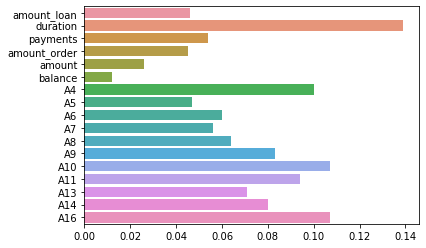

In [30]:
sns.barplot(variance_picking.named_steps['var_thres'].variances_.round(3),continuous_variables)

In [31]:
new_continuous_variables = [continuous_variables[value] 
                            for value in variance_picking.named_steps['var_thres'].get_support(indices=True)]
new_continuous_variables

# Univariate Selection

['amount_loan',
 'duration',
 'payments',
 'amount_order',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A13',
 'A14',
 'A16']

# Univariate Selection

In [33]:
combined_cat_variables = binary_variables + nominal_cat_variables
combined_cat_variables

['gender',
 'bank_to',
 'type_loan',
 'district_id',
 'frequency',
 'type_account',
 'A3']

In [37]:
from sklearn.feature_selection import chi2, SelectKBest

chi2_pipe_k = Pipeline([('ordinal_transform', OrdinalEncoder()),
                        ('SelectK', SelectKBest(score_func = chi2,
                                                k = 2))])

chi2_pipe_k.fit(x_train[combined_cat_variables],y_train)

Pipeline(memory=None,
         steps=[('ordinal_transform',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('SelectK',
                 SelectKBest(k=2,
                             score_func=<function chi2 at 0x7fd850dfb320>))],
         verbose=False)

In [38]:
new_categorical_variables = [combined_cat_variables[value] 
                               for value in chi2_pipe_k.named_steps['SelectK'].get_support(indices=True)]
new_categorical_variables

['district_id', 'type_account']

In [39]:
from sklearn.feature_selection import SelectFwe

chi2_pipe_fwe = Pipeline([('ordinal_transform', OrdinalEncoder()),
                         ('Selectfwe', SelectFwe(score_func = chi2, 
                                                 alpha = 0.05))])

chi2_pipe_fwe.fit(x_train[new_categorical_variables], y_train)

Pipeline(memory=None,
         steps=[('ordinal_transform',
                 OrdinalEncoder(categories='auto',
                                dtype=<class 'numpy.float64'>)),
                ('Selectfwe',
                 SelectFwe(alpha=0.05,
                           score_func=<function chi2 at 0x7fd850dfb320>))],
         verbose=False)

In [40]:
final_categorical_variables = [new_categorical_variables[value] 
                               for value in chi2_pipe_fwe.named_steps['Selectfwe'].get_support(indices=True)]
final_categorical_variables

['district_id', 'type_account']

# ANOVA

In [41]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

anova_pipe = Pipeline([('scaler', StandardScaler()),
                        ('anova', SelectKBest(score_func = f_classif,
                                             k = 'all'))])

anova_pipe.fit(x_train[new_continuous_variables], y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('anova',
                 SelectKBest(k='all',
                             score_func=<function f_classif at 0x7fd8517b7f80>))],
         verbose=False)

In [42]:
anova_pipe_fwe = Pipeline([('scaler', StandardScaler()),
                           ('select', SelectFwe(score_func = f_classif,
                                                alpha = 0.05))])

anova_pipe_fwe.fit(x_train[new_continuous_variables], y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('select',
                 SelectFwe(alpha=0.05,
                           score_func=<function f_classif at 0x7fd8517b7f80>))],
         verbose=False)

In [43]:
final_continuous_variables = [new_continuous_variables[value] 
                              for value in anova_pipe_fwe.named_steps['select'].get_support(indices=True)]
final_continuous_variables

['amount_loan',
 'payments',
 'amount_order',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A13',
 'A14',
 'A16']

# Modelling

In [52]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [44]:
from sklearn.compose import ColumnTransformer

data_transformer = ColumnTransformer(transformers = [
                                    ('continuous','passthrough', final_continuous_variables),
                                    ('binary', OrdinalEncoder(), final_categorical_variables)],
                                    remainder = 'drop')

## Null Model

In [49]:
from sklearn.tree import DecisionTreeClassifier

dt_null = Pipeline(steps= [('transform', data_transformer),
                           ('dt',DecisionTreeClassifier(random_state=42))])

dt_null.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('continuous', 'passthrough',
                                                  ['amount_loan', 'payments',
                                                   'amount_order', 'A4', 'A5',
                                                   'A6', 'A7', 'A8', 'A9',
                                                   'A10', 'A11', 'A13', 'A14',
                                                   'A16']),
                                                 ('binary',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>...
                                                   'type_account'])],
  

In [50]:
y_train_dt = dt_null.predict(x_train)
y_test_dt = dt_null.predict(x_test)

In [53]:
print(recall_score(y_train, y_train_dt, labels=['A','D'],pos_label='A'))
print(recall_score(y_test, y_test_dt, labels=['A','D'],pos_label='A'))

1.0
1.0


In [54]:
print(confusion_matrix(y_train, y_train_dt))
print(confusion_matrix(y_test, y_test_dt))

[[81112     0]
 [    0  2811]]
[[20314     0]
 [    0   667]]
